In [29]:
import torch.nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    y = torch.zeros(1, device=mps_device)
    print (x)
    print (y)
else:
    print ("MPS device not found.")

cpu_device = torch.device("cpu")
u = torch.ones(1, device=cpu_device)
v = torch.zeros(1, device=cpu_device)
print (u)
print (v)

tensor([1.], device='mps:0')
tensor([0.], device='mps:0')
tensor([1.])
tensor([0.])


In [3]:
# Loading .npy files into a torch dataset

class NumpyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data)
        #self.labels = torch.from_numpy(labels)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)
    
# Getting the data from the .npy files

import os
# iterate over the files in the directory

dataset_path = '../datasets/perov_PL_data/extracted_numpy/train/ACA/'
train_np_dataset = None
for filename in os.listdir(dataset_path):
    filepath = '../datasets/perov_PL_data/extracted_numpy/train/ACA/'+filename
    if train_np_dataset is None:
        train_np_dataset = np.load(filepath)
    else:
        train_np_dataset = np.concatenate((train_np_dataset, np.load(filepath)), axis=0)

print(train_np_dataset.shape)
print(train_np_dataset.dtype)
# Convert numpy dataset from unit to float32
train_np_dataset = train_np_dataset.astype(np.float32)
print(train_np_dataset.dtype)

# Get only the first channel which contains the entire PL spectrum
train_np_dataset = train_np_dataset[:,1,:,:]
print(train_np_dataset.shape)

#Preprocess image by dividing by max PL from all timesteps
max_PL = train_np_dataset.max()
print(max_PL)
train_np_dataset = train_np_dataset/max_PL

# Extract the labels for a particular substrate
label_dataset_path = '../datasets/perov_PL_data/extracted_numpy/train/labels.csv'
labels_dataset = pd.read_csv(label_dataset_path)
labels_dataset = labels_dataset[labels_dataset['substrateID'] == 'ACA']
print(labels_dataset.shape)

# Now adding to pytorch dataset
train_py_dataset = NumpyDataset(train_np_dataset)

(23008, 5, 65, 56)
uint16
float32
(23008, 65, 56)
5587.0
(32, 17)


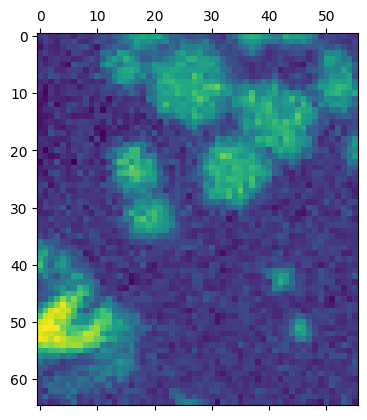

In [4]:
plt.matshow(train_py_dataset[500,:,:])

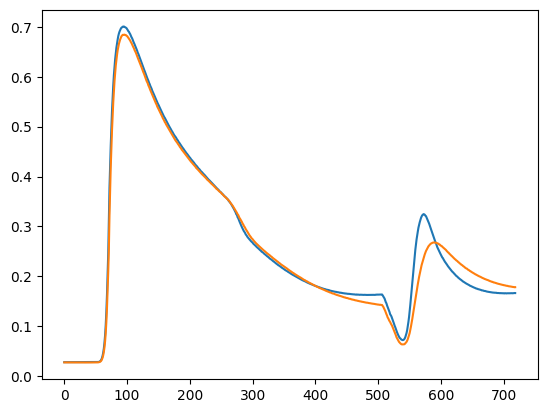

In [5]:
mean_PL_intensity1 = []
mean_PL_intensity2 = []
for i in range(719):
    mean_PL_intensity1.append(np.mean(train_py_dataset[i,:,:].numpy()))
    mean_PL_intensity2.append(np.mean(train_py_dataset[719 + i,:,:].numpy()))

plt.plot(range(719), mean_PL_intensity1)
plt.plot(range(719), mean_PL_intensity2)

In [34]:
# Build a convolutional autoencoder model to cluster the spatial inhomogenities in the PL data

class ConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder layers
        # Conv params :
        # Dilation -> Controls spacing b/w kernel elements. Dilation=1 is same as regular conv layers.
        # Padding  -> Applies a border of 0 pixel values to ht and wt. Value of 2 allows the output image to remain same size as input image. 
        # Stride   -> Controls sliding of kernel over the image. Always set to 1.
        # Maxpool2D then adds a padding onto the ht or wt to get an even value and then reduces the image size by half. By default stride is equal to kernel size.
        self.encoder = torch.nn.Sequential(
                            torch.nn.Conv2d(1, 1, kernel_size=5, stride=1, padding=2, dilation=1),
                            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=[1, 0], dilation=1, return_indices=False, ceil_mode=False),
                            torch.nn.ReLU(True),
                            torch.nn.Conv2d(1, 1, kernel_size=5, stride=1, padding=2, dilation=1),
                            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=[1, 0], dilation=1, return_indices=False, ceil_mode=False),
                            torch.nn.ReLU(True),
                            torch.nn.Conv2d(1, 1, kernel_size=5, stride=1, padding=2, dilation=1),
                            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=[1, 0], dilation=1, return_indices=False, ceil_mode=False),
                            torch.nn.ReLU(True),
                            torch.nn.Conv2d(1, 1, kernel_size=5, stride=1, padding=2, dilation=1),
                            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=[1, 1], dilation=1, return_indices=False, ceil_mode=False),
                            torch.nn.ReLU(True),
                            torch.nn.Flatten(start_dim=1, end_dim=-1),
                            torch.nn.Linear(20, 10),
                            torch.nn.ReLU(True))
        
        # self.conv1 = torch.nn.Conv2d(1, 1, kernel_size=5, stride=1, padding=2, dilation=1)
        # self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=[1, 0], dilation=1, return_indices=True, ceil_mode=False)
        # self.conv2 = torch.nn.Conv2d(1, 1, kernel_size=5, stride=1, padding=2, dilation=1)
        # self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=[1, 0], dilation=1, return_indices=True, ceil_mode=False)
        # self.conv3 = torch.nn.Conv2d(1, 1, kernel_size=5, stride=1, padding=2, dilation=1)
        # self.maxpool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=[1, 0], dilation=1, return_indices=True, ceil_mode=False)
        # self.conv4 = torch.nn.Conv2d(1, 1, kernel_size=5, stride=1, padding=2, dilation=1)
        # self.maxpool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=[1, 1], dilation=1, return_indices=True, ceil_mode=False)
        # self.linear1 = torch.nn.Linear(20, 10)

        # Decoder layers
        # Exp 1 : Using ConvTranspose2D
        self.linear2 = torch.nn.Linear(10, 20)
        self.convT1 = torch.nn.ConvTranspose2d(1, 1, kernel_size=5, stride=2, padding=2, output_padding=0, bias=True, dilation=1)
        self.convT2 = torch.nn.ConvTranspose2d(1, 1, kernel_size=5, stride=2, padding=2, output_padding=[0, 1], bias=True, dilation=1)
        self.convT3 = torch.nn.ConvTranspose2d(1, 1, kernel_size=5, stride=2, padding=2, output_padding=[0, 1], bias=True, dilation=1)
        self.convT4 = torch.nn.ConvTranspose2d(1, 1, kernel_size=5, stride=2, padding=2, output_padding=[0, 1], bias=True, dilation=1)
        # Exp 2 : Using Upsample + Conv2D layers 
        # Exp 3 : Using MaxUnpool2D + Conv2D layers

    def forward(self, x):
        # # Encoder layers
        # x = self.conv1(x)
        # # print(f'Conv out: {x.shape}')
        # x, ind1 = self.maxpool1(x)
        # x = x.relu()
        # # print(f'Pool out: {x.shape}')
        # x = self.conv2(x)
        # # print(f'Conv out: {x.shape}')
        # x, ind2 = self.maxpool2(x)
        # x = x.relu()
        # # print(f'Pool out: {x.shape}')
        # x = self.conv3(x)
        # # print(f'Conv out: {x.shape}')
        # x, ind3 = self.maxpool3(x)
        # x = x.relu()
        # # print(f'Pool out: {x.shape}')
        # x = self.conv4(x)
        # # print(f'Conv out: {x.shape}')
        # x, ind4 = self.maxpool4(x)
        # x = x.relu()
        # # print(f'Pool out: {x.shape}')
        # x = x.flatten(start_dim=1, end_dim=-1)
        # # print(x.shape)
        # l = self.linear1(x).relu()
        # # print(l.shape)
        l = self.encoder(x)

        # Decoder layers
        x = self.linear2(l).relu()
        # print(x.shape)
        # Input has to be of the form (minibatch, channels, height, width) for Upsample
        x = torch.nn.Unflatten(1, (1, 5, 4))(x)
        # print(x.shape)
        x = self.convT1(x).relu()
        # print(x.shape)
        # x = torch.nn.Upsample(size=(14, 12), mode='nearest')(x)
        # print(x.shape)
        x = self.convT2(x).relu()
        # print(x.shape)
        # x = torch.nn.Upsample(size=(31, 27), mode='nearest')(x)
        # print(x.shape)
        x = self.convT3(x).relu()
        # print(x.shape)
        x = self.convT4(x).sigmoid()
        # print(x.shape)
        return x
    
# Training the model
convAE = ConvAutoencoder().to(cpu_device)
criterion = torch.nn.L1Loss()

optimizer = torch.optim.Adam(
    convAE.parameters(), lr=0.001, weight_decay=1e-5)

train_loader = torch.utils.data.DataLoader(
    train_py_dataset, batch_size=1000, shuffle=True)   

# # Testing model on one example 
# plt.matshow(train_py_dataset[100,:,:])
# print(convAE(train_py_dataset[100,:,:].unsqueeze(0)))

num_epochs = 10
epoch_loss = []
for epoch in range(num_epochs):
    # Clock the time
    start_time = time.time()
    for data in train_loader:
        img = data.to(cpu_device).unsqueeze(1)
        # ===================forward=====================
        loss = criterion(convAE(img), img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('>', end='')
    # ===================log========================
    # Clock the time
    end_time = time.time()
    print(' epoch [{}/{}], loss:{:.4f}, time elapsed: {:.4f}'
          .format(epoch + 1, num_epochs, loss.item(), end_time - start_time))
    epoch_loss.append(loss.item())



 epoch [1/10], loss:0.2178, time elapsed: 17.9886
 epoch [2/10], loss:0.2441, time elapsed: 17.7972
 epoch [3/10], loss:0.2978, time elapsed: 17.4182
 epoch [4/10], loss:0.2691, time elapsed: 17.5035
 epoch [5/10], loss:0.1973, time elapsed: 17.8443
 epoch [6/10], loss:0.1900, time elapsed: 17.3252
 epoch [7/10], loss:0.1661, time elapsed: 17.5259
 epoch [8/10], loss:0.1441, time elapsed: 17.3052
 epoch [9/10], loss:0.1569, time elapsed: 17.4286
 epoch [10/10], loss:0.1234, time elapsed: 17.3928


(23008, 10)


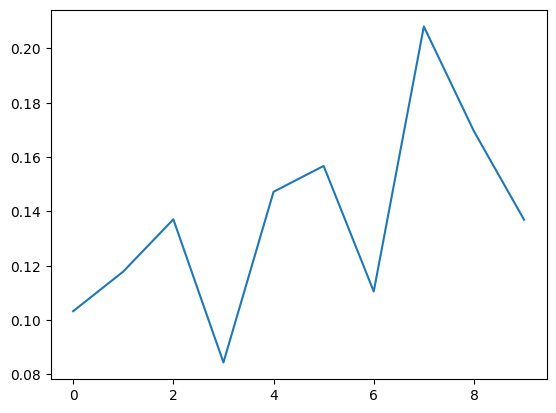

In [33]:
latents = []
for i in range(len(train_py_dataset)):
    latents.append(convAE.encoder(train_py_dataset[i,:,:].unsqueeze(0)).detach().numpy().squeeze())
latents = np.array(latents)
print(latents.shape)
latents_df = pd.DataFrame(latents)
latents_df.to_csv('latents.csv')

# Plot the loss
plt.plot(range(num_epochs), epoch_loss)

In [ ]:
# # Get the latent space representation of the data
# latent_space = []
# for i in range(719):
#     latent_space.append(convAE.encoder(train_py_dataset[i,:,:,:].unsqueeze(0)).detach().numpy())
# latent_space = np.array(latent_space)
# latent_space = latent_space.reshape((719,10))
# print(latent_space.shape)

# # Plot the latent space
# plt.scatter(latent_space[:,0], latent_space[:,1])

# # Plot the latent space with labels
# plt.scatter(latent_space[labels_dataset['label'] == 0,0], latent_space[labels_dataset['label'] == 0,1], color='red')
# plt.scatter(latent_space[labels_dataset['label'] == 1,0], latent_space[labels_dataset['label'] == 1,1], color='blue')
# plt.scatter(latent_space[labels_dataset['label'] == 2,0], latent_space[labels_dataset['label'] == 2,1], color='green')
# plt.scatter(latent_space[labels_dataset['label'] == 3,0], latent_space[labels_dataset['label'] == 3,1], color='yellow')
# plt.scatter(latent_space[labels_dataset['label'] == 4,0], latent_space[labels_dataset['label'] == 4,1], color='black')

In [19]:
print(latents)

[[0.0000000e+00 2.6984216e-38 0.0000000e+00 0.0000000e+00 2.2670392e-38
  0.0000000e+00 0.0000000e+00 1.0716926e-38 0.0000000e+00 9.9715194e-39]]


In [ ]:
# Save the model
torch.save(convAE.state_dict(), 'conv_autoencoder.pth')

# Load the model
convAE = ConvAutoencoder()
convAE.load_state_dict(torch.load('./conv_autoencoder.pth'))
convAE.eval()

In [ ]:
# Convolutional layer 1
hin = 65
win = 56
padding = 2
dilation = 1
kernel_size = 5
stride = 1
hout1 = (hin + 2*padding - dilation*(kernel_size-1) - 1)/stride + 1
wout1 = (win + 2*padding - dilation*(kernel_size-1) - 1)/stride + 1
print(f'Image size after conv layer : {hout1, wout1}')

# Maxpool layer  1
hin = hout1
win = wout1
pool_size = 2
stride = 2
hout2 = (hin - pool_size)/stride + 1
wout2 = (win - pool_size)/stride + 1
print(f'Image size after max pool layer : {hout2, wout2}')

# Convolutional layer 2
hin = hout2
win = wout2
padding = 2
dilation = 1
kernel_size = 5
stride = 1
hout3 = (hin + 2*padding - dilation*(kernel_size-1) - 1)/stride + 1
wout3 = (win + 2*padding - dilation*(kernel_size-1) - 1)/stride + 1
print(f'Image size after conv layer : {hout3, wout3}')

# Maxpool layer  2
hin = hout3
win = wout3
pool_size = 2
stride = 2
hout4 = (hin - pool_size)/stride + 1
wout4 = (win - pool_size)/stride + 1
print(f'Image size after max pool layer : {hout4, wout4}')

# Convolutional layer 3
hin = hout4
win = wout4
padding = 1
dilation = 1
kernel_size = 5
stride = 1
hout5 = (hin + 2*padding - dilation*(kernel_size-1) - 1)/stride + 1
wout5 = (win + 2*padding - dilation*(kernel_size-1) - 1)/stride + 1
print(f'Image size after conv layer : {hout5, wout5}')

# Maxpool layer  3
hin = hout5
win = wout5
pool_size = 2
stride = 2
hout6 = (hin - pool_size)/stride + 1
wout6 = (win - pool_size)/stride + 1
print(f'Image size after max pool layer : {hout6, wout6}')

In [ ]:
test = np.array([[[1, 2, 3], 
                  [4, 5, 6], 
                  [7, 8, 9]], 
                  
                  [[1, 2, 3], 
                   [4, 10, 6], 
                   [7, 8, 9]]
                  ], dtype=np.float32)

# Finding the max across all channels
print(test.max())

for i in range(2):
    test[i,:,:] = test[i,:,:]/test.max()
    print(test)
